## Ejemplo 1: Pruebas A/B

### 1. Objetivos:
    - Aprender a evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

El siguiente es un dataset obtenido con los resultados de una Prueba A/B. Se probaron dos flujos de venta distintos y se registró si cada uno de ellos resultó en una conversión (venta) o no. El test A es la hipótesis alternativa (la aplicada al grupo experimental), mientras que el test B es la hipótesis nula (la aplicada al grupo control).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/BEDU/Remoto Datasets/Remoto ab_test-sales_pipeline.csv')

df

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1
...,...,...,...
46322,B,0,1
46323,B,0,1
46324,B,0,1
46325,A,0,1


Lo primero que podemos hacer es agrupar nuestros resultados por 'test', para realizar un conteo de cuántas conversiones hubo con cada flujo de ventas:

In [4]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()

total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [5]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])
total_count

,conversion,no conversion,success rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [8]:
total_count.loc['B']['success rate'] / total_count.loc['A']['success rate']

0.9766462213779373

In [6]:
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100

In [9]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')

El test A fue 2.34% más `efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [10]:
all_measurements = df[['conversion', 'no conversion']]

In [12]:
all_measurements

,conversion,no conversion
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
46322,0,1
46323,0,1
46324,0,1
46325,0,1


Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [13]:
value_counts = df['test'].value_counts()

value_counts

A    23739
B    22588
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

In [15]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [17]:
a, b

(      test  conversion  no conversion
 155      A           0              1
 15425    B           0              1
 39471    B           0              1
 21248    A           0              1
 26529    A           0              1
 ...    ...         ...            ...
 25386    B           0              1
 45343    A           0              1
 180      A           0              1
 15935    B           0              1
 20184    A           0              1
 
 [23739 rows x 3 columns],       test  conversion  no conversion
 0        B           0              1
 2        A           0              1
 7        B           0              1
 16       A           0              1
 17       B           0              1
 ...    ...         ...            ...
 46319    A           0              1
 46321    B           0              1
 46323    B           0              1
 46325    A           0              1
 46326    A           0              1
 
 [22588 rows x 3 columns])

In [19]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,197,23542,185,22403
1,201,23538,181,22407
2,197,23542,185,22403
3,189,23550,193,22395
4,203,23536,179,22409
...,...,...,...,...
995,190,23549,192,22396
996,201,23538,181,22407
997,210,23529,172,22416
998,192,23547,190,22398


In [20]:
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [21]:
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,197,23542,185,22403,0.008299,0.008190
1,201,23538,181,22407,0.008467,0.008013
2,197,23542,185,22403,0.008299,0.008190
3,189,23550,193,22395,0.007962,0.008544
4,203,23536,179,22409,0.008551,0.007925
...,...,...,...,...,...,...
995,190,23549,192,22396,0.008004,0.008500
996,201,23538,181,22407,0.008467,0.008013
997,210,23529,172,22416,0.008846,0.007615
998,192,23547,190,22398,0.008088,0.008412


In [22]:
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,197,23542,185,22403,0.008299,0.008190,0.013061
1,201,23538,181,22407,0.008467,0.008013,0.053617
2,197,23542,185,22403,0.008299,0.008190,0.013061
3,189,23550,193,22395,0.007962,0.008544,-0.073199
4,203,23536,179,22409,0.008551,0.007925,0.073295
...,...,...,...,...,...,...,...
995,190,23549,192,22396,0.008004,0.008500,-0.062019
996,201,23538,181,22407,0.008467,0.008013,0.053617
997,210,23529,172,22416,0.008846,0.007615,0.139217
998,192,23547,190,22398,0.008088,0.008412,-0.040009


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


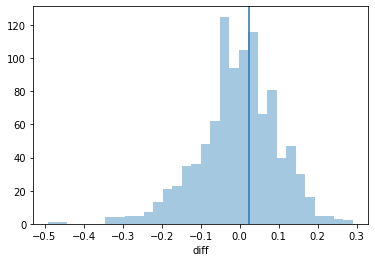

In [23]:
sns.distplot(perm_results['diff'], kde=False, norm_hist=False)

plt.axvline(diferencia_en_proporcion);

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [24]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.411

Este valor quiere decir que el 41.6% de los test que hicimos obtuvieron un valor igual o más extremo que el obtenido en el experimento. Esto está extremadamente alejado de un Alfa de 5%, y por lo tanto definitivamente nuestro resultado **no es estadísticamente significativo**.

# Reto 1

In [25]:
df = pd.read_csv('/content/drive/MyDrive/BEDU/Remoto Datasets/Remoto ab_test-sales_pipeline-2.csv')

df

,test,conversion,no conversion
0,A,0,1
1,B,0,1
2,A,0,1
3,A,0,1
4,B,0,1
...,...,...,...
76322,B,0,1
76323,A,0,1
76324,B,0,1
76325,B,1,0


In [31]:
total_count = df.groupby('test')[['conversion', 'no conversion']].sum()
total_count 
#Agrupamos por tratamiento y obtenemos la suma para conversion y no conversion

,conversion,no conversion
test,,
A,4163,30576
B,4841,36747


#### Cuantificar que flujo de ventas fue mejor

In [36]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])
total_count
#Calculamos la tasa de exito para cada tratamiento
#El tratamiento A, en primera vista tuvo una tasa de exito mas grande

,conversion,no conversion,success rate
test,,,
A,4163,30576,0.119836
B,4841,36747,0.116404


In [51]:
#Sacamos la proporcion de exito de B con respecto a A, tomando en cuenta que A obtuvo un mejor resultado.
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más `efectivo que el test B para generar ventas.')
diferencia_en_proporcion

El test A fue 2.86% más `efectivo que el test B para generar ventas.


0.028645069159369485

#### Test de permutacion

In [38]:
#Combinar los resultados de los test A y B en un dataframe
all_measurements = df[['conversion', 'no conversion']]

#Calcular el tamanio de los test para saber cuantas muestras tomar por cada sampling
value_counts = df['test'].value_counts()
value_counts

B    41588
A    34739
Name: test, dtype: int64

#### Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-5 `R` veces para obtener una distribución de la estadística de interés.

In [39]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False)
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    b = df.loc[~df.index.isin(a.index)]
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [40]:
perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b
0,4153,30586,4851,36737
1,4133,30606,4871,36717
2,4032,30707,4972,36616
3,4089,30650,4915,36673
4,3974,30765,5030,36558
...,...,...,...,...
995,4122,30617,4882,36706
996,4109,30630,4895,36693
997,4072,30667,4932,36656
998,4109,30630,4895,36693


In [41]:
#Ahora calculamos la tasa de exito para cada sampling a y b
perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [43]:
##Sacamos la proporcion de exito de b con respecto a 'a', tomando en cuenta que 
#estamos evaluando si A es mejor significativamente
perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])
perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,4153,30586,4851,36737,0.119549,0.116644,0.024295
1,4133,30606,4871,36717,0.118973,0.117125,0.015531
2,4032,30707,4972,36616,0.116066,0.119554,-0.030054
3,4089,30650,4915,36673,0.117706,0.118183,-0.004051
4,3974,30765,5030,36558,0.114396,0.120948,-0.057278
...,...,...,...,...,...,...,...
995,4122,30617,4882,36706,0.118656,0.117390,0.010675
996,4109,30630,4895,36693,0.118282,0.117702,0.004902
997,4072,30667,4932,36656,0.117217,0.118592,-0.011730
998,4109,30630,4895,36693,0.118282,0.117702,0.004902


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


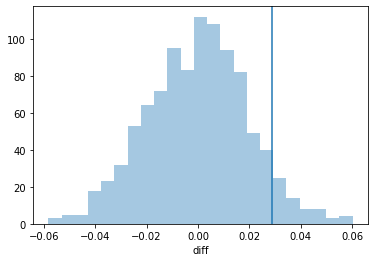

In [44]:
sns.distplot(perm_results['diff'], kde=False, norm_hist=False)
plt.axvline(diferencia_en_proporcion);

In [52]:
(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0] * 100

6.5

In [50]:
perm_results.shape

(1000, 7)

# Expresiones regulares

In [64]:
import pandas as pd
import nltk
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [56]:
dfreg = pd.read_csv('/content/drive/MyDrive/BEDU/Remoto Datasets/Remoto amazon_fine_food_reviews-clean.csv')

In [ ]:
dfreg

In [65]:
text=dfreg['text']
text

0        This coffee does NOT come in individual "PODS"...
1        I was a little skeptical after looking at the ...
2        Gloia Jeans Butter Toffee is one of my favorit...
3        My families and friends love Planters peanuts ...
4        Organic Valley White 1 % Milkfat Lowfat Milk, ...
                               ...                        
14206    This tea certainly exceeded my expectations!  ...
14207    I had these at a conference once. I have been ...
14208    I have enjoyed using the maple flavor. It adds...
14209    When I recently started using K-cups, wasn't s...
14210    I ordered these as I have ordered from Amazon ...
Name: text, Length: 14211, dtype: object

In [66]:
tokenized = text.apply(nltk.word_tokenize)

In [67]:
tokenized

0        [This, coffee, does, NOT, come, in, individual...
1        [I, was, a, little, skeptical, after, looking,...
2        [Gloia, Jeans, Butter, Toffee, is, one, of, my...
3        [My, families, and, friends, love, Planters, p...
4        [Organic, Valley, White, 1, %, Milkfat, Lowfat...
                               ...                        
14206    [This, tea, certainly, exceeded, my, expectati...
14207    [I, had, these, at, a, conference, once, ., I,...
14208    [I, have, enjoyed, using, the, maple, flavor, ...
14209    [When, I, recently, started, using, K-cups, ,,...
14210    [I, ordered, these, as, I, have, ordered, from...
Name: text, Length: 14211, dtype: object

In [68]:
# Sumamos todas las listas para obtener una lista con todas las palabras en nuestro conjunto de datos
# Creamos un objeto Text
all_words = tokenized.sum()
texttok = nltk.Text(all_words)
texttok

<Text: This coffee does NOT come in individual ``...>

In [ ]:
text.concordance('woman', lines=20)